In [1]:
import numpy as np 

import pandas as pd
import matplotlib.pyplot as plt
                    

In [2]:
#добавление помех

def add_error(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    with open(file_path, 'w') as file:
        file.write(lines[0])  
        for line in lines[1:]:
            parts = line.split()  
            parts[3] = f"{float(parts[3]) + 5:.7f}"  
            modified_line = (
                '     ' + parts[0] + '    ' + parts[1] + '    ' + parts[2] + '    ' + parts[3] + '   ' + parts[4] +
                '   ' + parts[5] + '   ' + parts[6] + '  ' + parts[7] + '  ' + parts[8] + '   ' + parts[9] + '  ' + parts[10] +
                '  ' + parts[11] + '\n'
            ) 
            file.write(modified_line)  # Записываем измененную строку
None

In [3]:
import subprocess
subprocess.run('experiments/vertical_axis/rotate_Y_period_5_amplitude_90/tt3axis.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#add_error('experiments/rotate_Y_period_5_amplitude_90/tt3axis.imu')
subprocess.run('experiments/vertical_axis/rotate_Y_period_5_amplitude_90/ins.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

subprocess.run('experiments/vertical_axis/rotate_Y_period_10_amplitude_90/tt3axis.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#add_error('experiments/rotate_Y_period_10_amplitude_90/tt3axis.imu')
subprocess.run('experiments/vertical_axis/rotate_Y_period_10_amplitude_90/ins.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
None


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import jv #Функция Бесселя осредненная на периоде

In [5]:
class Calibration:
    def __init__(self, fit_intercept=True,amplitude = np.pi/2, period = 5):
        self.fit_intercept = fit_intercept
        self.psi_a = amplitude
        self.period = period
    def fit(self, X, Y_v_e,Y_v_n):
        
        X = np.reshape(X,newshape = (-1,1))
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)
        X_poly = np.delete(X_poly, 0, axis = 1)
        
        model_v_e = LinearRegression().fit(X_poly,Y_v_e)
        model_v_n = LinearRegression().fit(X_poly,Y_v_n)
        self.v_e_coef = model_v_e.coef_
        self.v_n_coef = model_v_n.coef_
    def a_e(self,t):
        derivative_coef = [self.v_e_coef[0], 2 * self.v_e_coef[1], 3 * self.v_e_coef[2]]

        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2] 

    def a_n(self,t):
        derivative_coef = [self.v_n_coef[0], 2 * self.v_n_coef[1], 3 * self.v_n_coef[2]]
    
        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2]

    def c(self):
        b = self.psi_a * jv(1, self.psi_a)
        return 4 * b * (np.pi**2) / (self.period**2)

In [6]:
imu = pd.read_csv('/home/roman/Inav/inav-ins-sample-app/experiments/vertical_axis/rotate_Y_period_5_amplitude_90/tt3axis.imu',delim_whitespace=True, header=None, skiprows=1)
ins = pd.read_csv('/home/roman/Inav/inav-ins-sample-app/experiments/vertical_axis/rotate_Y_period_5_amplitude_90/ins.nav', delim_whitespace=True,skiprows=1)

In [7]:
#константы
ins = pd.read_csv('experiments/vertical_axis/rotate_Y_period_5_amplitude_90/ins.nav', delim_whitespace=True,skiprows=1)
rotate_ax = 2
ind_start = 4000 
ind_end = 14000 - 1
amplitude = np.pi/2

v_e = ins.iloc[ind_start:ind_end, 4].values
v_n = ins.iloc[ind_start:ind_end, 5].values

#
clb1 = Calibration( period = 5 )
clb1.fit(ins.iloc[ind_start:ind_end,0],v_e,v_n)

a_e1 = clb1.a_e(ins.iloc[ind_start,0])
a_n1 = clb1.a_n(ins.iloc[ind_start,0])

#
ins = pd.read_csv('experiments/vertical_axis/rotate_Y_period_10_amplitude_90/ins.nav', delim_whitespace=True,skiprows=1)

v_e = ins.iloc[ind_start:ind_end, 4].values
v_n = ins.iloc[ind_start:ind_end, 5].values
# 
clb2 = Calibration(period = 10)
clb2.fit(ins.iloc[ind_start:ind_end,0],v_e,v_n)

a_e2 = clb2.a_e(ins.iloc[ind_start,0])
a_n2 = clb2.a_n(ins.iloc[ind_start,0])
print("a_e2,a_n2 = ",a_e2,a_n2)

None

a_e2,a_n2 =  0.03522665609214096 -7.603788168420967e-05


In [8]:

if rotate_ax == 1:
    R_mat = R_mat = np.array([[-np.cos(mean_psi), np.sin(mean_psi)],
                  [-np.sin(mean_psi),  -np.cos(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_e2 - a_e1],
                            [a_n2 - a_n1]])) / (clb2.c() - clb1.c())
    r_zy = r[0]
    r_yz = r[1]
    print("[r_zy,r_yz] = ",r_zy,r_yz)
    
if rotate_ax == 2:
    R_mat = np.array([[np.cos(mean_psi), -np.sin(mean_psi)],
                  [np.sin(mean_psi),  np.cos(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_e2 - a_e1],
                            [a_n2 - a_n1]])) / (clb2.c() - clb1.c())
    r_xz = r[0]
    r_zx = r[1]
    print("[r_xz, r_zx] = ",r_xz, r_zx)

if rotate_ax == 3:
    R_mat = R_mat = np.array([[np.sin(mean_psi), -np.cos(mean_psi)],
                  [np.cos(mean_psi),  np.sin(mean_psi)]])



    r = np.dot(R_mat, np.array([[a_e2 - a_e1],
                            [a_n2 - a_n1]])) / (clb2.c() - clb1.c())
    r_yx = r[0]
    r_xy = r[1]

    print("[r_yx,r_xy] = ",r_yx,r_xy)
    


None

NameError: name 'mean_psi' is not defined

# Визуализация

In [ ]:
fig1, axs1 = plt.subplots(3,2, figsize = (12,10))

axs1[0,0].plot(imu.iloc[:,0])
axs1[0,0].grid()
axs1[0,0].title.set_text("W1")

axs1[1,0].plot(imu.iloc[:,1])
axs1[1,0].grid()
axs1[1,0].title.set_text("W2")

axs1[2,0].plot(imu.iloc[:,2])
axs1[2,0].grid()
axs1[2,0].title.set_text("W3")

#Курс, крен, тангаж
axs1[0,1].plot(ins.iloc[:,0],ins.iloc[:,7])
axs1[0,1].grid()
axs1[0,1].title.set_text("roll")

axs1[1,1].plot(ins.iloc[:,0],ins.iloc[:,8])
axs1[1,1].grid()
axs1[1,1].title.set_text("pitch")

axs1[2,1].plot(ins.iloc[:,0], ins.iloc[:,9] )
axs1[2,1].grid()
axs1[2,1].title.set_text("heading")
axs1[2,1].set_ylim(-100,100)


None

In [ ]:
fig,axs = plt.subplots(2,1, figsize = (10,8))
axs[0].plot(ins.iloc[ind_start:ind_end, 0], v_e, label='V_E')
#axs[0].plot(ins.iloc[ind_start:ind_end, 0], a_e(ins.iloc[ind_start:ind_end, 0].values),label = "a_e")
axs[0].plot(ins.iloc[ind_start:ind_end, 0], model_v_e.predict(X_poly), label='Predicted_V_E', linestyle='--')
axs[0].set_title('Линейная регрессия с полиномиальными признаками')
axs[0].legend()
axs[0].set_ylim(-1,10)
axs[0].set_xlim(80,85)
axs[0].grid()

axs[1].plot(ins.iloc[ind_start:ind_end, 0], v_n, label='V_N')
axs[1].plot(ins.iloc[ind_start:ind_end, 0], model_v_n.predict(X_poly), label='Predicted_V_N', linestyle='--')
#axs[1].plot(ins.iloc[ind_start:ind_end, 0],a_n(ins.iloc[ind_start : ind_end, 0]),label = "a_n")
axs[1].set_title('Линейная регрессия с полиномиальными признаками')
axs[1].legend()
axs[1].set_ylim(-1,1)
axs[1].set_xlim(0,300)
axs[1].grid()



In [ ]:
#График скороксти V_E и V_N
fig, axs = plt.subplots(1,1 ,figsize = (12,6))
axs.plot(ins.iloc[:,0],ins.iloc[:,4])
axs.plot(ins.iloc[:,0],ins.iloc[:,5])
axs.plot(ins.iloc[:,0],ins.iloc[:,6])
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,4],linestyle = "dotted",color = "red")
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,5],linestyle = "dotted",color = "red")
axs.plot(ins.iloc[ind_start:ind_end,0],ins.iloc[ind_start:ind_end,6],linestyle = "dotted",color = "red")

axs.legend(['V_E','V_N','V_U'])

axs.grid()
axs.set_xlim(0,600)
#axs.set_ylim(0,)

None

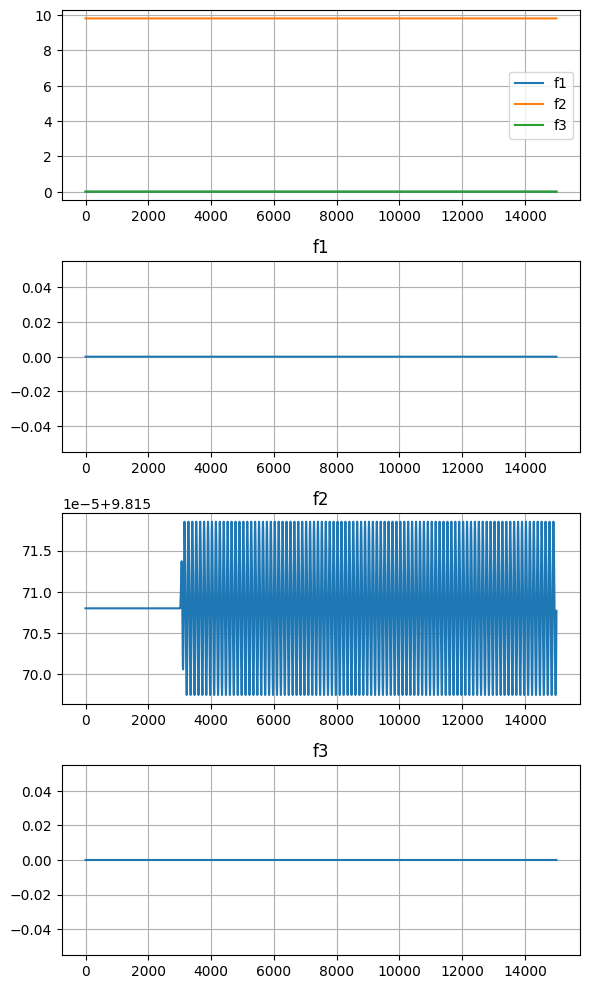

In [9]:

# График показаний акселерометров 
fig, axs = plt.subplots(4,1, figsize = (6,10))
axs[0].plot(imu.iloc[:,3],label ="f1")
axs[0].plot(imu.iloc[:,4],label ="f2")
axs[0].plot(imu.iloc[:,5],label ="f3")
axs[0].grid()
axs[0].legend()

axs[1].plot(imu.iloc[:,3])
axs[1].title.set_text("f1")
axs[1].grid()

axs[2].plot(imu.iloc[:,4])
axs[2].title.set_text("f2")
axs[2].grid()

axs[3].plot(imu.iloc[:,5])
axs[3].title.set_text("f3")
axs[3].grid()

plt.tight_layout()
plt.show()


# Оценка разнесений для реального БИНС

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
                    

In [11]:

#Config----
Amplitude = 90 #degree 
period = 60    #s
const_time = 10#s сумарное время стояния
accel_time = 2 #s сумарное время разгона
Om_0 = 5       # degree/s  
Eps = 10       # degree/s^2



G = np.array([[1, 2, 3],
     [6, 1, 4],
     [7, 2, 5]])

U, S, V = np.linalg.svd(G)
G = U

P_k =np.array([[1, 0, 0],
               [0, 1, 0],
               [0, 0, 1]]) 

z = np.random.rand(3,1)*100

#----------


In [12]:
def Q_i(P_k,g_i):
    A = np.dot(P_k.T, g_i)
    return np.dot(A,A.T)


K = np.zeros((3,3,3))
F = np.dot(P_k.T,G.T)
for i in range(3):
    g_i = (G[i,:])
    g_i = g_i.reshape(-1, 1)
    Q = Q_i(P_k,g_i)
    A1 = np.array([[0,   0     ,  0     ],
                   [ 0, -Q[2,2],  Q[2,1]],
                   [ 0,  Q[1,2], -Q[1,1]] ]) 
    A1[1:3] = A1[1:3]*4*np.sin(Amplitude)*Om_0/period

    A2 = np.array([[0, -Q[0,1], -Q[0,2] ],
                   [0, -Q[1,1], -Q[1,2] ],
                   [0, -Q[2,1], -Q[2,2] ] ])
    A2[0] = A2[0] * (Om_0**2) * (period - const_time) / period
    A2[1:3] =  A2[1:3] * (Om_0**2) * accel_time * np.cos(Amplitude) / period
    K[i,:,:] = np.dot(A1 + A2, F)    



H = np.concatenate((K[0, :, 1].reshape(-1, 1),
                     K[0, :, 2].reshape(-1, 1),
                     K[1, :, 0].reshape(-1, 1),
                     K[1, :, 2].reshape(-1, 1),
                     K[2, :, 0].reshape(-1, 1),
                     K[2, :, 1].reshape(-1, 1)), axis=1)


inv = np.linalg.pinv(H)

x =np.dot(inv,z)  

print(x)

#[r_xy, r_xz, r_yx, r_yz, r_xz, r_zy]

[[  0.8185168 ]
 [-42.02054249]
 [-50.54832136]
 [ 34.02149969]
 [-46.58089791]
 [  9.9459849 ]]


In [13]:
a = np.array([1,1])
print(a)
a.reshape(-1, 1)
print(a)

[1 1]
[1 1]


In [14]:
a = np.array([1,2])
b = np.array([1,1])
c = np.array([2,3])

print(np.concatenate((a,b,c),axis = -1))

[1 2 1 1 2 3]


In [15]:
from scipy.special import jv

In [16]:
jv(1,2.387)

0.5229414816329464

## Горизонтальная ось вращения

In [36]:
import subprocess
subprocess.run('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_35/tt3axis.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#add_error('experiments/rotate_Y_period_5_amplitude_90/tt3axis.imu')
subprocess.run('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_35/ins.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

subprocess.run('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_45/tt3axis.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
#add_error('experiments/rotate_Y_period_10_amplitude_90/tt3axis.imu')
subprocess.run('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_45/ins.exe',stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
None


In [37]:
class Calibration_gorizontal:
    def __init__(self, fit_intercept=True,amplitude = np.pi/2, period = 5):
        self.fit_intercept = fit_intercept
        self.psi_a = amplitude
        self.period = period
    def fit(self, X, Y_v_1,Y_v_3):
        
        X = np.reshape(X,newshape = (-1,1))
        poly = PolynomialFeatures(degree=3)
        X_poly = poly.fit_transform(X)
        X_poly = np.delete(X_poly, 0, axis = 1)
        
        model_v_1 = LinearRegression().fit(X_poly,Y_v_1)
        model_v_3 = LinearRegression().fit(X_poly,Y_v_3)
        self.v_1_coef = model_v_1.coef_
        self.v_3_coef = model_v_3.coef_
    def a_1(self,t):
        derivative_coef = [self.v_1_coef[0], 2 * self.v_1_coef[1], 3 * self.v_1_coef[2]]

        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2] 

    def a_3(self,t):
        derivative_coef = [self.v_3_coef[0], 2 * self.v_3_coef[1], 3 * self.v_3_coef[2]]
    
        return derivative_coef[0] + t * derivative_coef[1] + (t ** 2) * derivative_coef[2]

    def c(self):
        return 16 * self.psi_a * np.sin(self.psi_a) / (self.period**2)

In [44]:
#константы
ins = pd.read_csv('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_35/ins.nav', delim_whitespace=True,skiprows=1)
rotate_ax = 1
ind_start = 4000 
ind_end = 14000 - 1
amplitude = np.pi/2

v_1 = ins.iloc[ind_start:ind_end, 4].values
v_3 = ins.iloc[ind_start:ind_end, 6].values

#
clb1 = Calibration_gorizontal( period = 35 )
clb1.fit(ins.iloc[ind_start:ind_end,0],v_1,v_3)

a_perpend1 = clb1.a_1(ins.iloc[ind_start,0])
a_vertical1 = clb1.a_3(ins.iloc[ind_start,0])

#
ins = pd.read_csv('experiments/gorizontal_axis/uniform_rotate_Z_amplitude_90_T_45/ins.nav', delim_whitespace=True,skiprows=1)

v_1 = ins.iloc[ind_start:ind_end, 4].values
v_3 = ins.iloc[ind_start:ind_end, 6].values
# 
clb2 = Calibration_gorizontal(period = 45)
clb2.fit(ins.iloc[ind_start:ind_end,0],v_1,v_3)

a_perpend2 = clb2.a_1(ins.iloc[ind_start,0])
a_vertical2 = clb2.a_3(ins.iloc[ind_start,0])
print("a_e2,a_n2 = ",a_e2,a_n2)

None

a_e2,a_n2 =  0.03522665609214096 -7.603788168420967e-05


In [43]:
mean_psi = np.pi/2;
if rotate_ax == 1:
    #первая и вторая строчка поменяны местами 
    R_mat = np.array([[-np.sin(mean_psi),  -np.cos(mean_psi)],
                        [-np.cos(mean_psi), np.sin(mean_psi)]])
    

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c() - clb1.c())
    r_zy = r[0]
    r_yz = r[1]
    print("[r_zy,r_yz] = ",r_zy,r_yz)
    
if rotate_ax == 2:
    R_mat = np.array([[np.sin(mean_psi),  np.cos(mean_psi)],
                       [np.cos(mean_psi), -np.sin(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c() - clb1.c())
    r_xz = r[0]
    r_zx = r[1]
    print("[r_xz, r_zx] = ",r_xz, r_zx)

if rotate_ax == 3:
    R_mat = R_mat = np.array([[np.sin(mean_psi), -np.cos(mean_psi)],
                  [np.cos(mean_psi),  np.sin(mean_psi)]])

    r = np.dot(R_mat, np.array([[a_vertical2 - a_vertical1],
                            [a_perpend2 - a_perpend1]])) / (clb2.c() - clb1.c())
    
    r_yx = r[0]
    r_xy = r[1]

    print("[r_yx,r_xy] = ",r_yx,r_xy)
    


None

[r_zy,r_yz] =  [-0.42201678] [-2.58410749e-17]
